# Odhad CDPF

## Cíl analýzy

Cílem analýzy je odhad neoklasické agregátní CDPF.

## Data a metoda

Pro odhad byly použity následující hodnoty:

- hrubá přidaná hodnota (Gross Value Added) (převedená na stálé ceny roku 2010 pomocí deflátoru HDP),
- čistý fixní nefinanční kapitál (převedený na stálé ceny roku 2010 pomocí deflátoru kapitálových zásob),
- celkový počet odpracovaných hodin.

In [36]:
import eurostat
import pandas
import statsmodels.formula.api as smf
import numpy
import seaborn

LOCATIONS = ["CZ", "DE", "AT", "EU27_2020", "ES"]
BASE_LOCATION = "CZ"
START_YEAR = 1980
END_YEAR = 2020

### Hrubá přidaná hodnota (Gross Value Added)

Hrubá přidaná hodnota je načtena na základě kódu `nama_10_a10`.

In [37]:
data_1_es = eurostat.get_data_df('nama_10_a10')
data_1 = data_1_es
# Value added, gross
data_1 = data_1[data_1["na_item"] == "B1G"]
# Total, all NACE activities
data_1 = data_1[data_1["nace_r2"] == "TOTAL"]
# Current prices, million euro
data_1 = data_1[data_1["unit"].isin(["CP_MNAC", "PD10_NAC"])]
data_1 = pandas.melt(data_1, id_vars=["unit", "na_item", "geo\\time"], value_vars=list(range(START_YEAR, END_YEAR + 1)),
                     value_name="value", var_name="year")
data_1 = data_1.pivot(index=["na_item", "geo\\time", "year"], columns="unit", values="value")
data_1 = data_1.reset_index()
data_1 = data_1.rename({"CP_MNAC": "gross_value_added", "PD10_NAC": "gross_value_added_deflator"}, axis=1)
data_1["gross_value_added"] = data_1["gross_value_added"] * data_1["gross_value_added_deflator"]
data_1 = data_1.dropna()
data_1.tail()

unit,na_item,geo\time,year,gross_value_added,gross_value_added_deflator
1840,B1G,XK,2016,547200.4080,112.890
1841,B1G,XK,2017,577304.7840,113.064
1842,B1G,XK,2018,617278.2520,114.740
1843,B1G,XK,2019,661185.7636,116.026
1844,B1G,XK,2020,660210.0975,118.095


Pro data provedeme logaritmizaci a určíme hodnoty diferencí.

In [38]:
data_1 = data_1.sort_values(["geo\\time", "year"])
data_1["ln_gross_value_added"] = numpy.log(data_1["gross_value_added"])
data_1["ln_gross_value_added_t_minus_1"] = data_1.groupby("geo\\time")["ln_gross_value_added"].shift(1)
data_1["ln_gross_value_added_diff"] = (data_1["ln_gross_value_added"] - data_1["ln_gross_value_added_t_minus_1"]) / data_1["ln_gross_value_added"]
data_1 = data_1[["geo\\time", "year", "ln_gross_value_added", "ln_gross_value_added_diff"]]
data_1.tail()

unit,geo\time,year,ln_gross_value_added,ln_gross_value_added_diff
1840,XK,2016,13.212570,0.004012
1841,XK,2017,13.266126,0.004037
1842,XK,2018,13.333075,0.005021
1843,XK,2019,13.401790,0.005127
1844,XK,2020,13.400313,-0.000110


Dále načteme informace o odpracovaných hodinách, které mají kód `nama_10_a10_e`.

In [39]:
data_2_es = eurostat.get_data_df('nama_10_a10_e')
data_2 = data_2_es
# Total employment domestic concept
data_2 = data_2[data_2["na_item"] == "EMP_DC"]
# Total, all NACE activities
data_2 = data_2[data_2["nace_r2"] == "TOTAL"]
# Thousands hours worked
data_2 = data_2[data_2["unit"] == "THS_HW"]
data_2 = pandas.melt(data_2, id_vars=["unit", "na_item", "geo\\time"], value_vars=list(range(START_YEAR, END_YEAR + 1)),
                    value_name="thousands_hours_worked", var_name="year")
data_2 = data_2.sort_values(["geo\\time", "year"])
data_2 = data_2.dropna()
data_2["ln_thousands_hours_worked"] = numpy.log(data_2["thousands_hours_worked"])
data_2["ln_thousands_hours_worked_t_minus_1"] = data_2.groupby("geo\\time")["ln_thousands_hours_worked"].shift(1)
data_2["ln_thousands_hours_worked_diff"] = (data_2["ln_thousands_hours_worked"] - data_2["ln_thousands_hours_worked_t_minus_1"]) / data_2["ln_thousands_hours_worked"]
data_2 = data_2[["geo\\time", "year", "ln_thousands_hours_worked", "ln_thousands_hours_worked_diff"]]
data_2.head()

,geo\time,year,ln_thousands_hours_worked,ln_thousands_hours_worked_diff
585,AT,1995,15.666346,NaN
624,AT,1996,15.688559,0.001416
663,AT,1997,15.700493,0.000760
702,AT,1998,15.698566,-0.000123
741,AT,1999,15.715818,0.001098


Jako předposlední krok je načten čistý fixní nefinanční kapitál, který má kód `nama_10_nfa_bs`.

In [40]:
data_3_es = eurostat.get_data_df('nama_10_nfa_bs')

data_3 = data_3_es
data_3 = eurostat.get_data_df('nama_10_nfa_bs')
# Total fixed assets (net)
data_3 = data_3[data_3["asset10"] == "N11N"]
# Total, all activities
data_3 = data_3[data_3["sector"] == "S1"]
# Current fixed prices, millions of national currency
data_3 = data_3[data_3["unit"] == "CP_MNAC"]
data_3 = pandas.melt(data_3, id_vars=["unit", "asset10", "geo\\time"], value_vars=list(range(START_YEAR, END_YEAR + 1)),
                    value_name="total_fixed_assets", var_name="year")
data_3 = data_3.sort_values(["geo\\time", "year"])
data_3 = data_3.dropna()

V posledním kroku je načten deflátor kapitálových zásob, který má kód `nama_10_nfa_fl`.

In [41]:
data_4_es = eurostat.get_data_df('nama_10_nfa_fl')

data_4 = data_4_es
data_4 = data_4[data_4["asset10"] == "N11G"]
data_4 = data_4[data_4["nace_r2"] == "TOTAL"]
data_4 = data_4[data_4["unit"] == "PD10_NAC"]
data_4 = pandas.melt(data_4, id_vars=["unit", "asset10", "geo\\time"], value_vars=list(range(START_YEAR, END_YEAR + 1)),
                    value_name="capital_stock_deflator", var_name="year")
data_4 = data_4.sort_values(["geo\\time", "year"])
data_4 = data_4.dropna()

Hodnota kapitálu je nyní převedena na stálé ceny roku 2010.

In [42]:
data_3 = data_3.merge(data_4, on=["geo\\time", "year"])
data_3["total_fixed_assets"] = data_3["total_fixed_assets"] * data_3["capital_stock_deflator"]
data_3["ln_total_fixed_assets"] = numpy.log(data_3["total_fixed_assets"])
data_3["ln_total_fixed_assets_t_minus_1"] = data_3.groupby("geo\\time")["ln_total_fixed_assets"].shift(1)
data_3["ln_total_fixed_assets_diff"] = (data_3["ln_total_fixed_assets"] - data_3["ln_total_fixed_assets_t_minus_1"]) / data_3["ln_total_fixed_assets"]
data_3 = data_3[["geo\\time", "year", "ln_total_fixed_assets", "ln_total_fixed_assets_diff"]]

Jako poslední krok provedeme spojní všech tabulek do jedné.

In [43]:
data = pandas.merge(data_1, data_2, on=["geo\\time", "year"])
data = pandas.merge(data, data_3, on=["geo\\time", "year"])
data.head()

,geo\time,year,ln_gross_value_added,ln_gross_value_added_diff,ln_thousands_hours_worked,ln_thousands_hours_worked_diff,ln_total_fixed_assets,ln_total_fixed_assets_diff
0,AT,1995,16.381579,NaN,15.666346,NaN,17.736362,NaN
1,AT,1996,16.417358,0.002179,15.688559,0.001416,17.789630,0.002994
2,AT,1997,16.455536,0.002320,15.700493,0.000760,17.841370,0.002900
3,AT,1998,16.498469,0.002602,15.698566,-0.000123,17.884289,0.002400
4,AT,1999,16.535190,0.002221,15.715818,0.001098,17.926085,0.002332


Níže je graf vztahu mezi diferencí logaritmovaného čistého fixního finančního kapitálu a diferencí logaritmované
hrubé přidané hodnoty.
Z grafu je patrná jistá korelace mezi proměnnými.

C:\Users\jirip\repos\deotn\venv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y, data. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


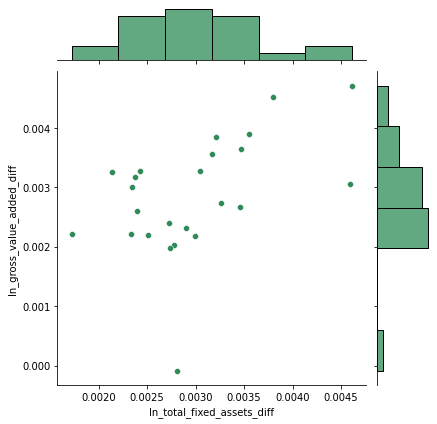

In [55]:
data_plot = data[data["geo\\time"] == "AT"]
seaborn.jointplot("ln_total_fixed_assets_diff", "ln_gross_value_added_diff", data_plot, kind='scatter', color='seagreen')

Níže je graf vztahu mezi diferencí logaritmovaných odpracovaných hodin a diferencí logaritmované
hrubé přidané hodnoty.
Zde je korelace očividně výrazně slabší.

C:\Users\jirip\repos\deotn\venv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y, data. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


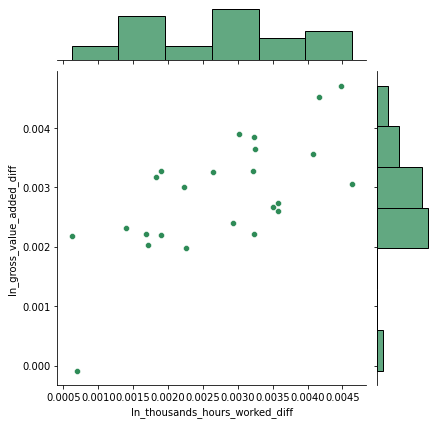

In [56]:
data_plot = data[data["geo\\time"] == "AT"]
seaborn.jointplot("ln_thousands_hours_worked_diff", "ln_gross_value_added_diff", data_plot, kind='scatter', color='seagreen')

Hodnoty korelace jsou v korelační matici

In [46]:
data_plot[["ln_total_fixed_assets_diff", "ln_gross_value_added_diff", "ln_thousands_hours_worked_diff"]].corr()

,ln_total_fixed_assets_diff,ln_gross_value_added_diff,ln_thousands_hours_worked_diff
ln_total_fixed_assets_diff,1.000000,0.902269,-0.025181
ln_gross_value_added_diff,0.902269,1.000000,0.077221
ln_thousands_hours_worked_diff,-0.025181,0.077221,1.000000


Na základě korelační matice je zřejmé, že výsledky regresního modelu nebudou dobré.

In [57]:
data_plot = data[data["geo\\time"] == "AT"]

data_plot = data_plot[data_plot["year"] > 1996]

mod = smf.ols(formula="ln_gross_value_added_diff ~ ln_thousands_hours_worked_diff + ln_total_fixed_assets_diff", data=data_plot)
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                OLS Regression Results                               
=====================================================================================
Dep. Variable:     ln_gross_value_added_diff   R-squared:                       0.475
Model:                                   OLS   Adj. R-squared:                  0.422
Method:                        Least Squares   F-statistic:                     9.041
Date:                       Fri, 10 Dec 2021   Prob (F-statistic):            0.00160
Time:                               10:10:20   Log-Likelihood:                 134.17
No. Observations:                         23   AIC:                            -262.3
Df Residuals:                             20   BIC:                            -258.9
Df Model:                                  2                                         
Covariance Type:                   nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept                          0.0008      0.001      1.217      0.238      -0.001       0.002
ln_thousands_hours_worked_diff     0.6020      0.202      2.976      0.007       0.180       1.024
ln_total_fixed_assets_diff         0.1172      0.294      0.399      0.694      -0.496       0.731
==============================================================================
Omnibus:                        1.567   Durbin-Watson:                   1.278
Prob(Omnibus):                  0.457   Jarque-Bera (JB):                1.391
Skew:                          -0.500   Prob(JB):                        0.499
Kurtosis:                       2.328   Cond. No.                     2.08e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.08e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Alternativně bylo vyzkoušen celkový objem mezd. Zde je korelace podstatně vyšší, bohužel do sebe ale výše mezd
"natahuje" růst produktivity práce, čímž tento model nevyhovuje našemu zadání.

C:\Users\jirip\repos\deotn\venv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y, data. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


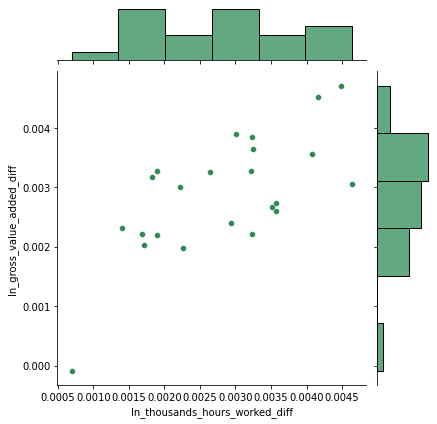

In [59]:
data_2_es = eurostat.get_data_df('nama_10_a10')
data_2 = data_2_es

data_2 = data_2[data_2["na_item"] == "D11"]

data_2 = data_2[data_2["nace_r2"] == "TOTAL"]

data_2 = data_2[data_2["unit"] == "CP_MNAC"]
data_2 = pandas.melt(data_2, id_vars=["unit", "na_item", "geo\\time"], value_vars=list(range(START_YEAR, END_YEAR + 1)),
                    value_name="thousands_hours_worked", var_name="year")
data_2 = data_2.sort_values(["geo\\time", "year"])
data_2 = data_2.dropna()
data_2["ln_thousands_hours_worked"] = numpy.log(data_2["thousands_hours_worked"])
data_2["ln_thousands_hours_worked_t_minus_1"] = data_2.groupby("geo\\time")["ln_thousands_hours_worked"].shift(1)
data_2["ln_thousands_hours_worked_diff"] = (data_2["ln_thousands_hours_worked"] - data_2["ln_thousands_hours_worked_t_minus_1"]) / data_2["ln_thousands_hours_worked"]
data_2 = data_2[["geo\\time", "year", "ln_thousands_hours_worked", "ln_thousands_hours_worked_diff"]]

data = pandas.merge(data_1, data_2, on=["geo\\time", "year"])
data = pandas.merge(data, data_3, on=["geo\\time", "year"])

data_plot = data[data["geo\\time"] == "AT"]
data_plot = data_plot[data_plot["year"] > 1996]
seaborn.jointplot("ln_thousands_hours_worked_diff", "ln_gross_value_added_diff", data_plot, kind='scatter', color='seagreen')

Níže je test stacionarity

In [60]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(data_plot["ln_thousands_hours_worked_diff"])
f"p-hodnota testu stacionarity je {result[1]}"

'p-hodnota testu stacionarity je 0.11747181078733021'

In [61]:
result = adfuller(data_plot["ln_gross_value_added_diff"])
f"p-hodnota testu stacionarity je {result[1]}"

'p-hodnota testu stacionarity je 0.0005063271799016991'

Časová řada u čistých aktiv bohužel vychází jako nestacionární

In [62]:
result = adfuller(data_plot["ln_total_fixed_assets_diff"])
f"p-hodnota testu stacionarity je {result[1]}"

'p-hodnota testu stacionarity je 0.05851587455007578'

Následně provedeme test kointegrace.

In [52]:
import statsmodels.tsa.stattools as ts

result=ts.coint(data_plot["ln_gross_value_added_diff"], data_plot["ln_thousands_hours_worked_diff"])
f"p-hodnota testu kointegrace je {result[1]}"

'p-hodnota testu kointegrace je 0.9859002580259643'

In [53]:
result = ts.coint(data_plot["ln_gross_value_added_diff"], data_plot["ln_total_fixed_assets_diff"])
f"p-hodnota testu kointegrace je {result[1]}"

'p-hodnota testu kointegrace je 0.9859002580259643'

Součet koeficientů regresního modelu je mírně vyšší než 1.

In [65]:
mod = smf.ols(formula="ln_gross_value_added_diff ~ ln_thousands_hours_worked_diff + ln_total_fixed_assets_diff", data=data_plot)
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                OLS Regression Results                               
=====================================================================================
Dep. Variable:     ln_gross_value_added_diff   R-squared:                       0.475
Model:                                   OLS   Adj. R-squared:                  0.422
Method:                        Least Squares   F-statistic:                     9.041
Date:                       Fri, 10 Dec 2021   Prob (F-statistic):            0.00160
Time:                               10:17:32   Log-Likelihood:                 134.17
No. Observations:                         23   AIC:                            -262.3
Df Residuals:                             20   BIC:                            -258.9
Df Model:                                  2                                         
Covariance Type:                   nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept                          0.0008      0.001      1.217      0.238      -0.001       0.002
ln_thousands_hours_worked_diff     0.6020      0.202      2.976      0.007       0.180       1.024
ln_total_fixed_assets_diff         0.1172      0.294      0.399      0.694      -0.496       0.731
==============================================================================
Omnibus:                        1.567   Durbin-Watson:                   1.278
Prob(Omnibus):                  0.457   Jarque-Bera (JB):                1.391
Skew:                          -0.500   Prob(JB):                        0.499
Kurtosis:                       2.328   Cond. No.                     2.08e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.08e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""